In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-water-quality-data/water_dataX.csv


In [2]:
import os 
print(os.listdir("../input/indian-water-quality-data"))

['water_dataX.csv']


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load and preprocess the data
df = pd.read_csv("../input/indian-water-quality-data/water_dataX.csv", encoding='unicode_escape')
df = df.iloc[0:1900, :]
df = df.rename(columns={"D.O. (mg/l)": "DO", "CONDUCTIVITY (µmhos/cm)": "Conductivity", "B.O.D. (mg/l)": "BOD", 
                        "NITRATENAN N+ NITRITENANN (mg/l)": "NI", "FECAL COLIFORM (MPN/100ml)": "Fec_col", 
                        "TOTAL COLIFORM (MPN/100ml)Mean": "Tot_col"})

In [5]:
# Dropping unwanted features
df_num = df.drop(["STATION CODE", "NI", "LOCATIONS", "STATE", "year", "BOD", "Fec_col", "Tot_col"], axis=1)
df_num

,Temp,DO,PH,Conductivity
0,30.6,6.7,7.5,203
1,29.8,5.7,7.2,189
2,29.5,6.3,6.9,179
3,29.7,5.8,6.9,64
4,29.5,5.8,7.3,83
...,...,...,...,...
1895,27,7.4,7,88.5
1896,NAN,6.6,7.81,603.2
1897,28,6.6,7.49,571.5
1898,28,5.4,7.16,75.8


In [6]:
num_col = df.shape[1]
for index in range(num_col):
    col_name = df.iloc[:, index].name
    df[col_name] = pd.to_numeric(df[col_name], errors="coerce")

df.dtypes

STATION CODE    float64
LOCATIONS       float64
STATE           float64
Temp            float64
DO              float64
PH              float64
Conductivity    float64
BOD             float64
NI              float64
Fec_col         float64
Tot_col         float64
year              int64
dtype: object

In [7]:
# Convert all columns to numeric, coerce errors to NaN
df_num = df_num.apply(pd.to_numeric, errors='coerce')

In [8]:
def convert_to_nan(df):
    n_col = df.shape[1]
    for index in range(n_col):
        df.iloc[:, index]  = df.iloc[:, index].replace("NAN", np.nan)
    return df

df = convert_to_nan(df)
df.isnull().sum().sort_values()

year               0
PH                 7
Conductivity      24
DO                30
BOD               42
Temp              89
STATION CODE     120
Tot_col          130
NI               189
Fec_col          280
LOCATIONS       1900
STATE           1900
dtype: int64

In [9]:
# Convert all columns to numeric, coerce errors to NaN
df_num = df_num.apply(pd.to_numeric, errors='coerce')

# Function to replace "NAN" strings with np.nan
def convert_to_nan(df):
    n_col = df.shape[1]
    for index in range(n_col):
        df.iloc[:, index] = df.iloc[:, index].replace("NAN", np.nan)
    return df

df_num = convert_to_nan(df_num)

In [10]:
# Impute missing values with median
imputer = SimpleImputer(strategy="median")
df_num = pd.DataFrame(imputer.fit_transform(df_num), columns=df_num.columns)


In [11]:
# Detecting and removing outliers using Z-Score
def detect_outliers_zscore(df, threshold=3):
    z_scores = zscore(df)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < threshold).all(axis=1)
    return df[filtered_entries]

df_num = detect_outliers_zscore(df_num)


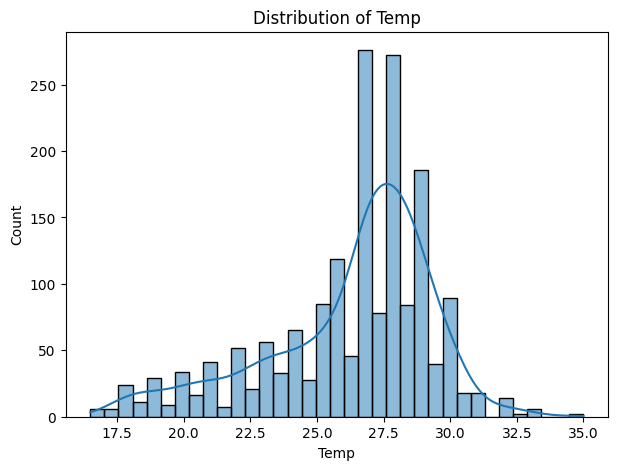

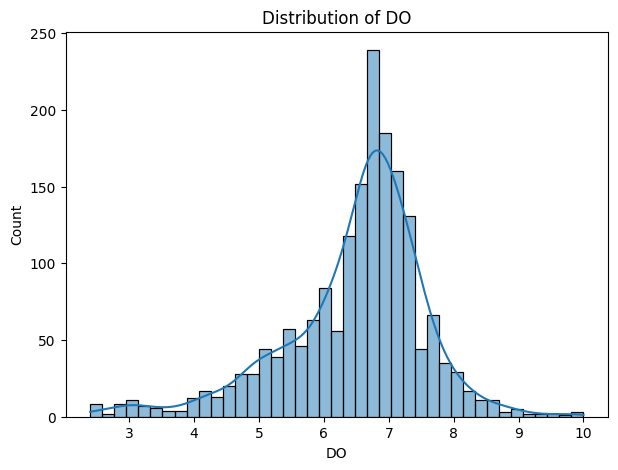

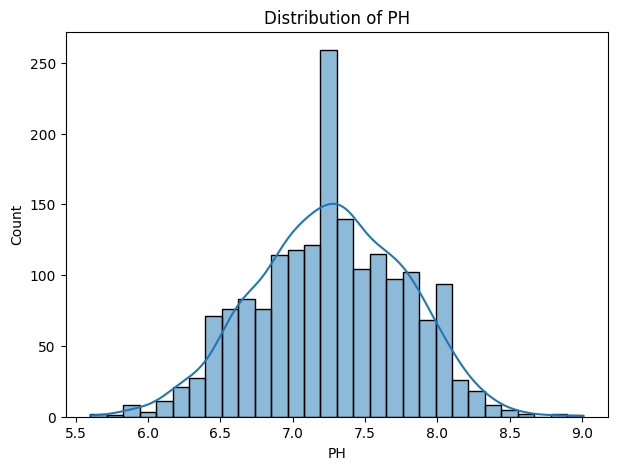

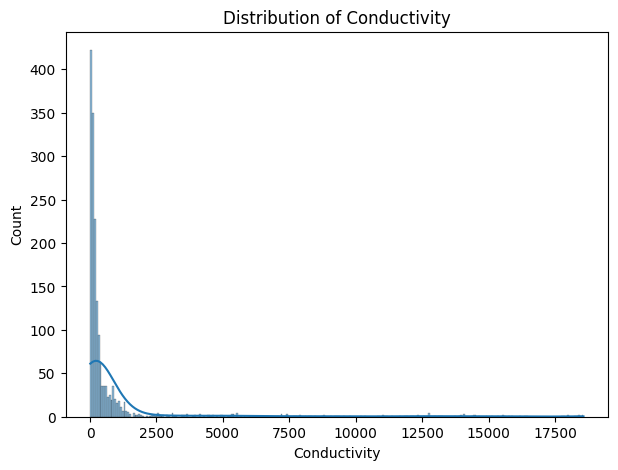

In [12]:
# Plot histograms
def plot_histograms(df):
    for col in df.columns:
        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
        sns.histplot(df[col], kde=True, ax=ax)
        ax.set_title(f'Distribution of {col}')
        plt.show()

plot_histograms(df_num)


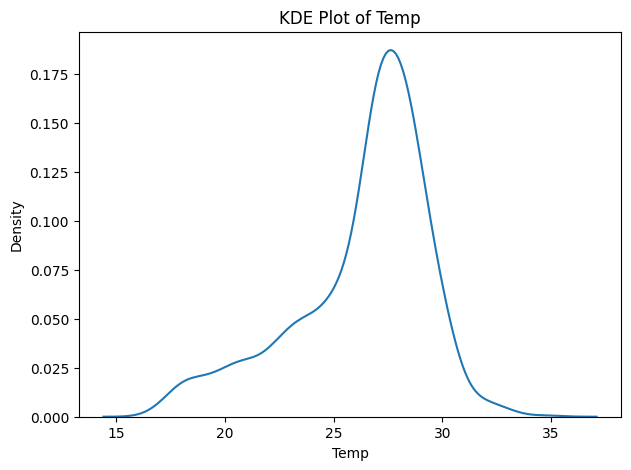

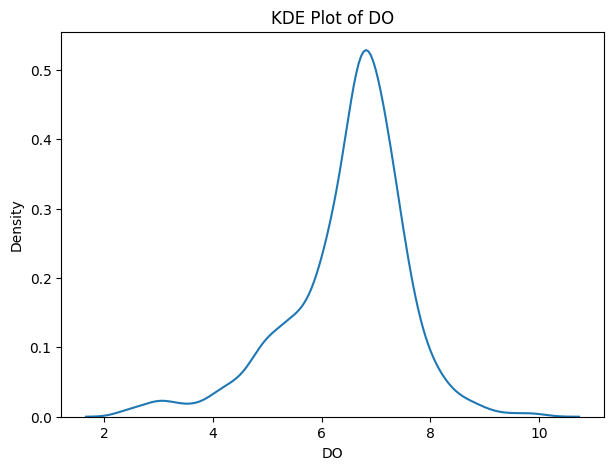

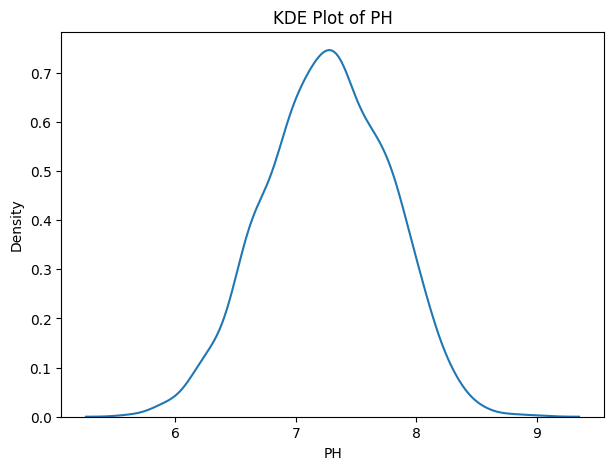

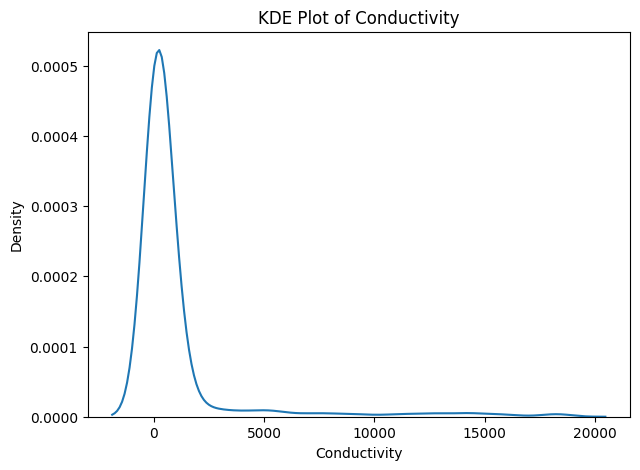

In [13]:
# KDE plots
def plot_kde(df):
    for col in df.columns:
        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
        sns.kdeplot(data=df, x=col, ax=ax)
        ax.set_title(f'KDE Plot of {col}')
        plt.show()

plot_kde(df_num)

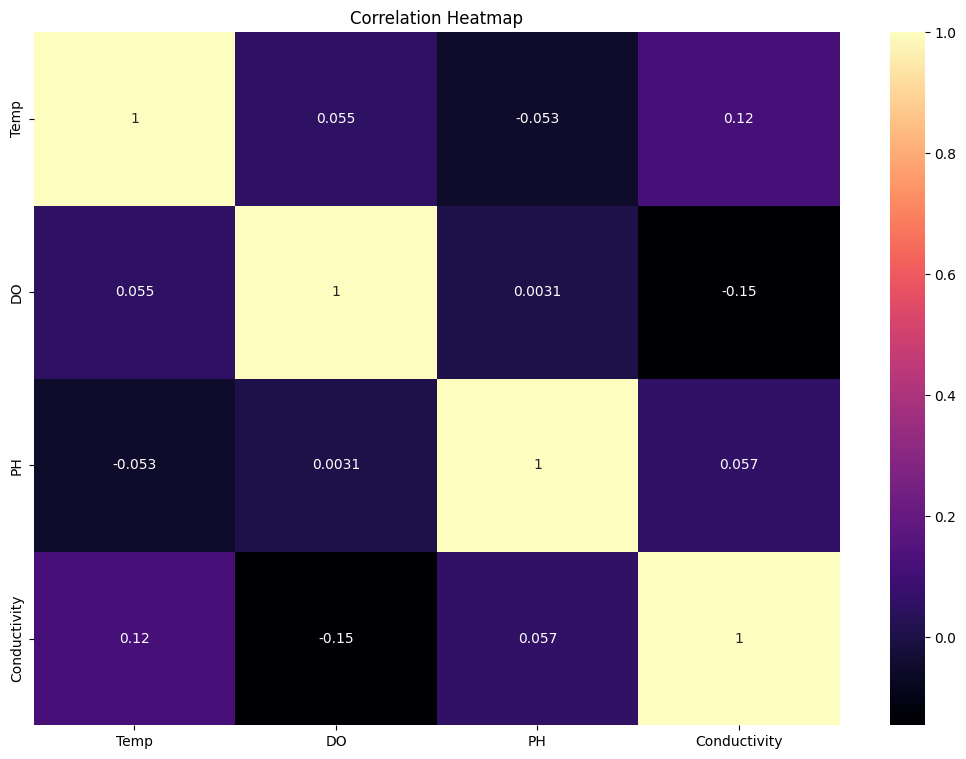

In [14]:
# Correlation heatmap
corr = df_num.corr()
fig, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(corr, annot=True, cmap='magma', ax=ax)
plt.title('Correlation Heatmap')
plt.show()

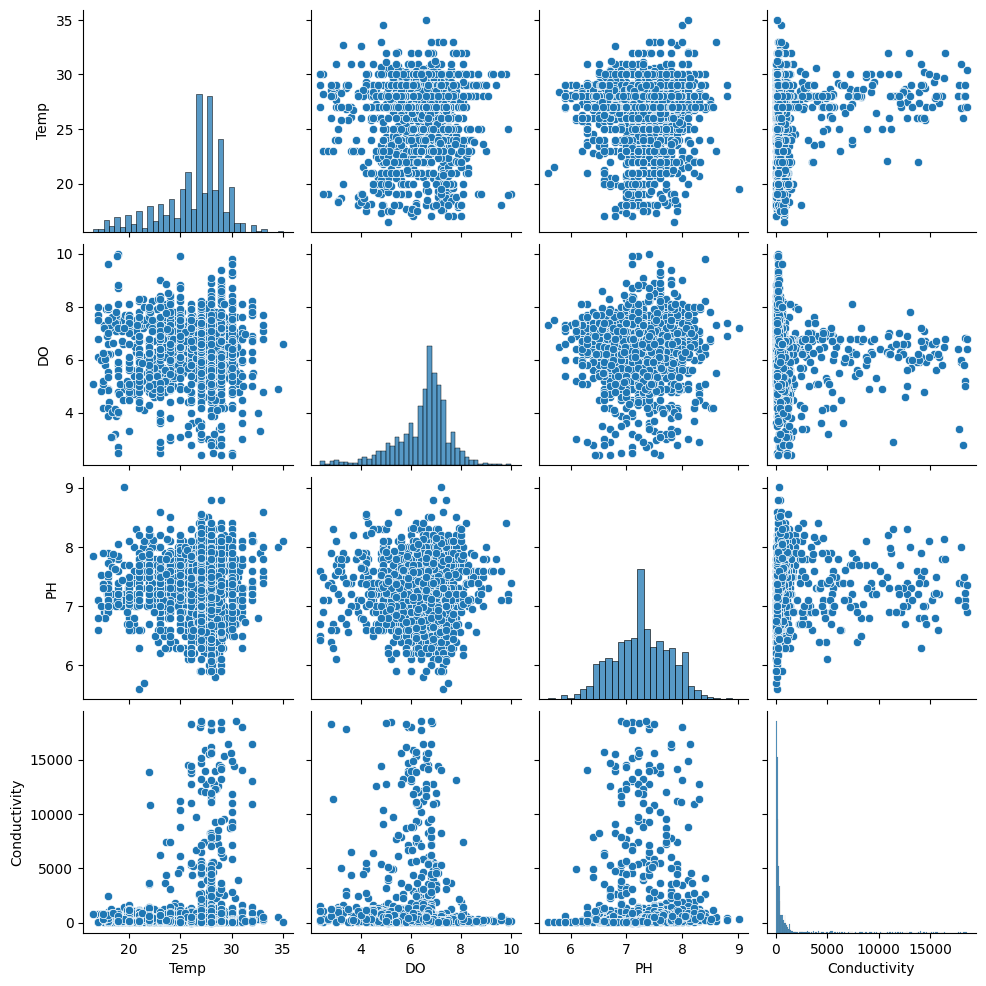

In [15]:
# Pairplot
sns.pairplot(df_num)
plt.show()

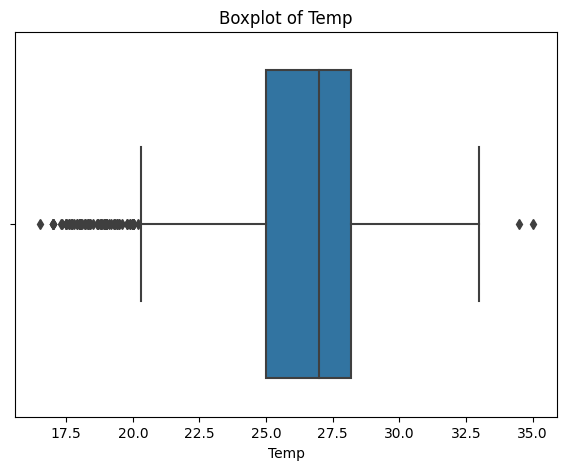

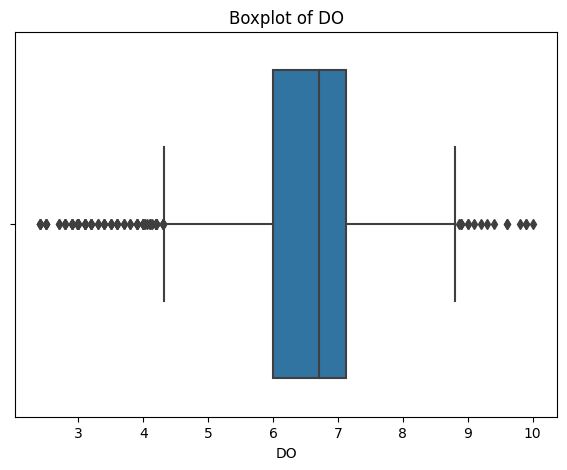

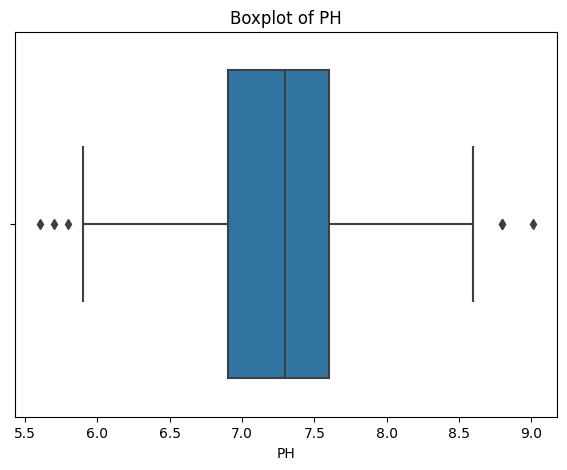

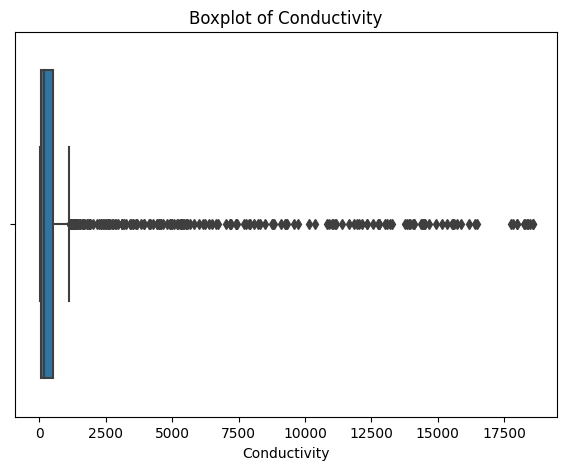

In [16]:
# Boxplot
def plot_boxplots(df):
    for col in df.columns:
        fig, ax = plt.subplots(1, 1, figsize=(7, 5))
        sns.boxplot(data=df, x=col, ax=ax)
        ax.set_title(f'Boxplot of {col}')
        plt.show()

plot_boxplots(df_num)

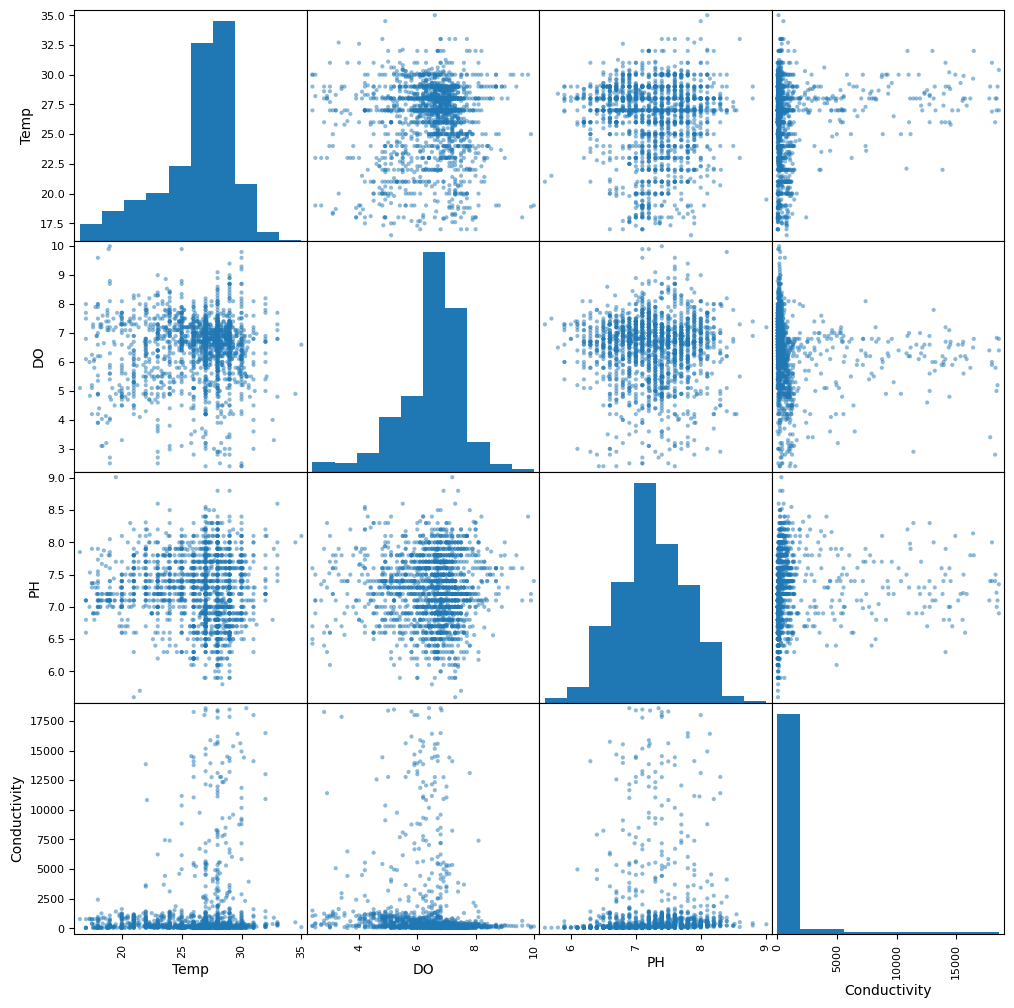

In [17]:
# Scatter plot matrix
pd.plotting.scatter_matrix(df_num, figsize=(12, 12))
plt.show()

In [18]:
# Redefining df_num based on the previously processed dataframe
df_num = df.drop(["STATION CODE", "NI", "LOCATIONS", "STATE", "year", "BOD", "Fec_col", "Tot_col"], axis=1)
df_num = df_num.apply(pd.to_numeric, errors='coerce')
df_num = convert_to_nan(df_num)
df_num


,Temp,DO,PH,Conductivity
0,30.6,6.7,7.50,203.0
1,29.8,5.7,7.20,189.0
2,29.5,6.3,6.90,179.0
3,29.7,5.8,6.90,64.0
4,29.5,5.8,7.30,83.0
...,...,...,...,...
1895,27.0,7.4,7.00,88.5
1896,NaN,6.6,7.81,603.2
1897,28.0,6.6,7.49,571.5
1898,28.0,5.4,7.16,75.8


In [19]:
# Replacing NULL values with median of column
imputer = SimpleImputer(strategy="median")
df_num = pd.DataFrame(imputer.fit_transform(df_num), columns=df_num.columns)
df_num

,Temp,DO,PH,Conductivity
0,30.6,6.7,7.50,203.0
1,29.8,5.7,7.20,189.0
2,29.5,6.3,6.90,179.0
3,29.7,5.8,6.90,64.0
4,29.5,5.8,7.30,83.0
...,...,...,...,...
1895,27.0,7.4,7.00,88.5
1896,27.0,6.6,7.81,603.2
1897,28.0,6.6,7.49,571.5
1898,28.0,5.4,7.16,75.8


In [20]:
# Compute Z-Score
df_num = detect_outliers_zscore(df_num)
df_num

,Temp,DO,PH,Conductivity
0,30.6,6.7,7.50,203.0
1,29.8,5.7,7.20,189.0
2,29.5,6.3,6.90,179.0
3,29.7,5.8,6.90,64.0
4,29.5,5.8,7.30,83.0
...,...,...,...,...
1895,27.0,7.4,7.00,88.5
1896,27.0,6.6,7.81,603.2
1897,28.0,6.6,7.49,571.5
1898,28.0,5.4,7.16,75.8


In [21]:
# Temp has nothing to do with WQI, so dropping
df_num.drop(["Temp"], axis=1, inplace=True)

In [22]:
# Weight Vector (wi)
wi = np.array([0.2213, 0.2604, 0.0022])
wi

array([0.2213, 0.2604, 0.0022])

In [23]:
# Standard values of parameters (si)
si = np.array([10, 8.5, 1000])
si

array([  10. ,    8.5, 1000. ])

In [24]:
# Ideal values of parameters (vIdeal)
vIdeal = np.array([14.6, 7, 0])

def calc_wqi(sample): 
    wqi_sample = 0
    num_col = 3
    for index in range(num_col):
        v_index = sample[index]  # Observed value of sample at index
        v_index_ideal = vIdeal[index]  # Ideal value of observed value
        w_index = wi[index]  # Weight of corresponding parameter of observed value
        std_index = si[index]  # Standard value recommended for observed value
        q_index = (v_index - v_index_ideal) / (std_index - v_index_ideal)
        q_index = q_index * 100  # Final qi value of observed value
        wqi_sample += q_index * w_index
    return wqi_sample
def calc_wqi_for_df(df):
    wqi_arr = []
    for index in range(df.shape[0]):
        index_row = df.iloc[index, :]
        wqi_row = calc_wqi(index_row)
        wqi_arr.append(wqi_row)
    return wqi_arr

wqi_arr = calc_wqi_for_df(df_num)
wqi_arr = np.array(wqi_arr).reshape(-1, 1)
# wqi_df = pd.DataFrame(wqi_arr, columns=["WQI"])
wqi_arr

array([[46.73052957],
       [46.33031913],
       [38.23359739],
       ...,
       [47.11908652],
       [47.054276  ],
       [50.706256  ]])

In [25]:
# Combining dataframe of WQI and dataframe of attributes
df_wqi = pd.concat([df_num.reset_index(drop=True), pd.DataFrame(wqi_arr, columns=["WQI"])], axis=1)
df_wqi

,DO,PH,Conductivity,WQI
0,6.7,7.50,203.0,46.730530
1,5.7,7.20,189.0,46.330319
2,6.3,6.90,179.0,38.233597
3,5.8,6.90,64.0,40.613732
4,5.8,7.30,83.0,47.561912
...,...,...,...,...
1768,7.4,7.00,88.5,34.657731
1769,6.6,7.81,603.2,52.681261
1770,6.6,7.49,571.5,47.119087
1771,5.4,7.16,75.8,47.054276


In [26]:
#  Removing the samples with negative WQI
df_wqi = df_wqi[df_wqi["WQI"] >= 0]
df_wqi.head()

,DO,PH,Conductivity,WQI
0,6.7,7.5,203.0,46.730530
1,5.7,7.2,189.0,46.330319
2,6.3,6.9,179.0,38.233597
3,5.8,6.9,64.0,40.613732
4,5.8,7.3,83.0,47.561912


In [27]:
# WQI classification
df_wqi["WQI clf"] = df_wqi["WQI"].apply(lambda x: 4 if x <= 25 else 3 if 26 <= x <= 50 else 2 if 51 <= x <= 75 else 1 if 76 <= x <= 100 else 0)

In [28]:
features = list(df_wqi.columns)[:]
data_cluster = df_wqi['WQI clf']
data_cluster.describe()

count    1773.000000
mean        2.624365
std         0.766035
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         4.000000
Name: WQI clf, dtype: float64

 WQI Range                   Classification

     Less than 25                  Excellent(3)
        26–50                         Good(2)
        51-75                         Poor(1)
    Greater than 75                 Very Poor(0)

In [29]:
df_wqi["WQI clf"] = df_wqi["WQI"].apply(lambda x: (4 if (x <= 25)
                                        else(3 if (26<=x<=50)
                                        else(2 if (51<=x<=75)
                                        else(1 if (76<=x<=100)
                                        else 0)))))
df_wqi.head(10)

,DO,PH,Conductivity,WQI,WQI clf
0,6.7,7.5,203.0,46.730530,3
1,5.7,7.2,189.0,46.330319,3
2,6.3,6.9,179.0,38.233597,3
3,5.8,6.9,64.0,40.613732,3
4,5.8,7.3,83.0,47.561912,3
5,5.5,7.4,81.0,50.740733,0
6,6.1,6.7,308.0,35.752151,3
7,6.4,6.7,414.0,34.332210,3
8,6.4,7.6,305.0,49.932230,3
9,6.3,7.6,77.0,50.363157,0


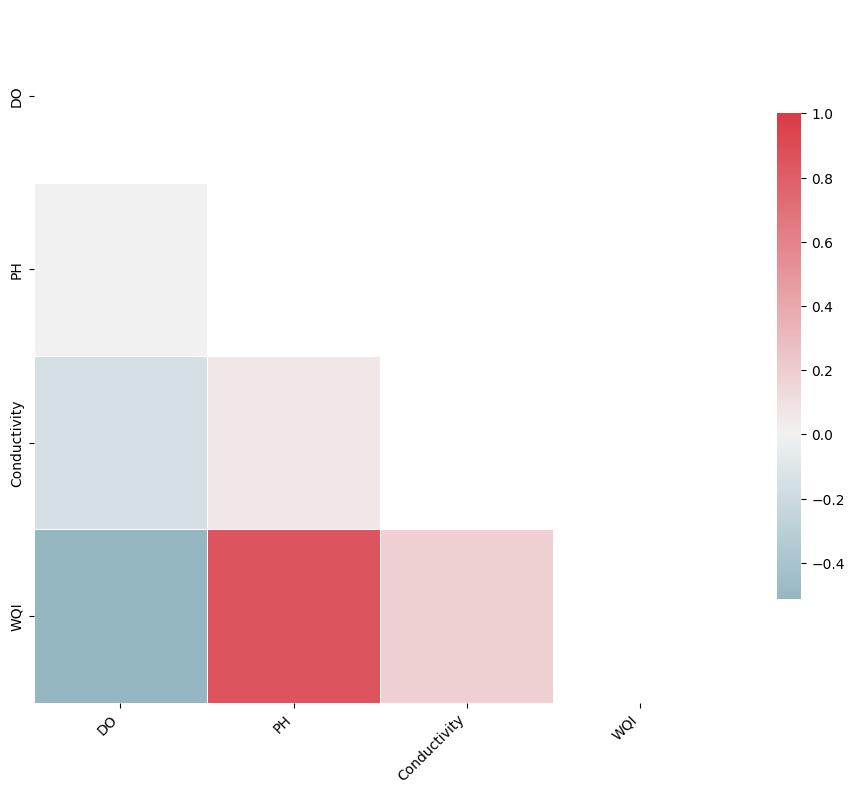

In [30]:
# Correlation heatmap
corr = df_wqi[["DO", "PH", "Conductivity", "WQI"]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(13, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .7})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

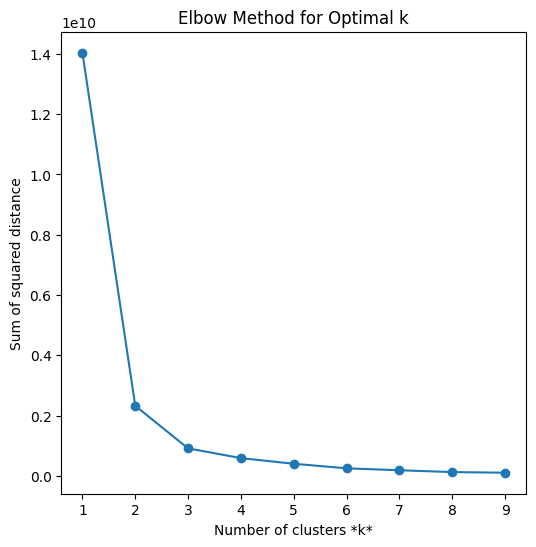

In [31]:
# KMeans clustering and Elbow method
features = list(df_wqi.columns)[:3]
data_f = df_wqi[features]

# Ensure data_f is not empty before proceeding
if data_f.empty:
    raise ValueError("No data available in data_f. Please check the data preprocessing steps.")

sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(data_f)
    sse.append(km.inertia_)
    
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.title('Elbow Method for Optimal k')
plt.show()

In [32]:
# Logistic Regression
Y = df_wqi['WQI clf']
X = df_wqi[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=30)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy:  0.952112676056338
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00         1
           2       0.96      1.00      0.98        92
           3       0.95      1.00      0.97       238
           4       1.00      0.67      0.80        12

    accuracy                           0.95       355
   macro avg       0.58      0.53      0.55       355
weighted avg       0.92      0.95      0.93       355

Confusion Matrix:
 [[  0   0   3   9   0]
 [  0   0   1   0   0]
 [  0   0  92   0   0]
 [  0   0   0 238   0]
 [  0   0   0   4   8]]


In [33]:
# Clustering with Silhouette Score
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_scaled)
labels = kmeans.labels_
silhouette_score(X_scaled, labels, metric='euclidean') # silhouette

0.33339325350169874

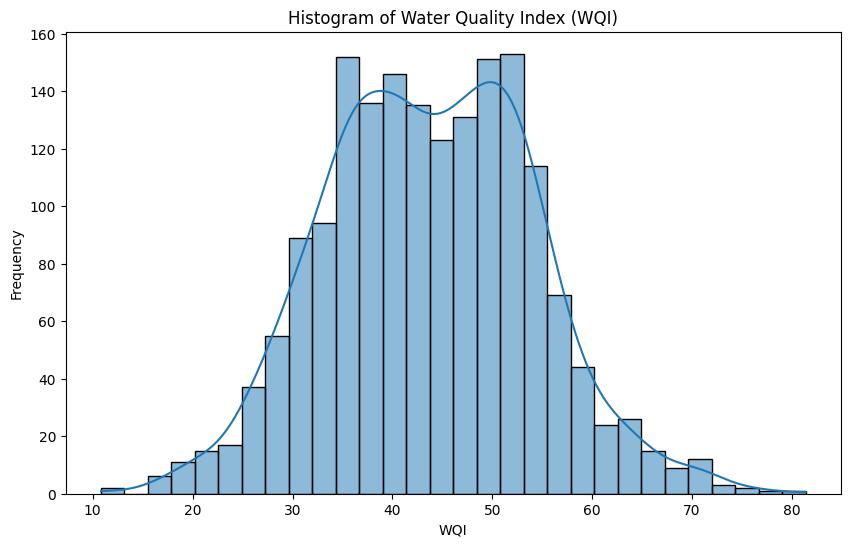

In [34]:
# Histogram for WQI
plt.figure(figsize=(10, 6))
sns.histplot(df_wqi['WQI'], bins=30, kde=True)
plt.title('Histogram of Water Quality Index (WQI)')
plt.xlabel('WQI')
plt.ylabel('Frequency')
plt.show()


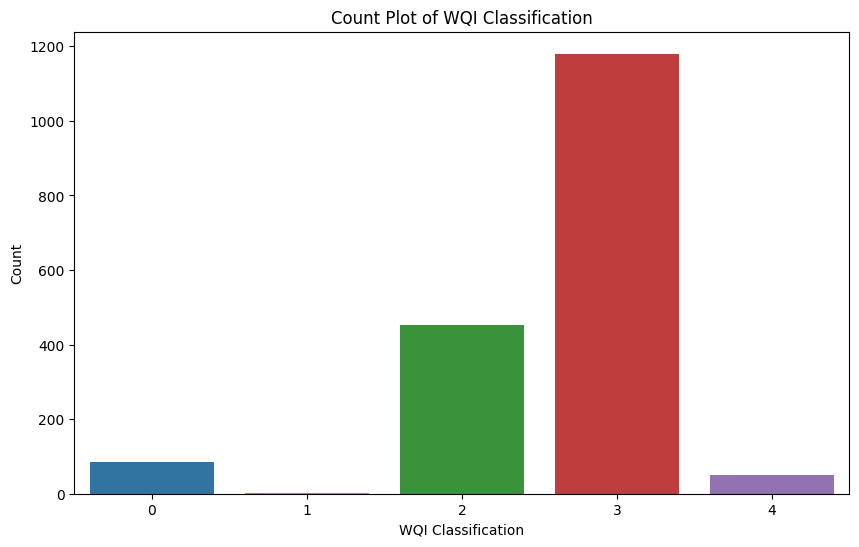

In [35]:
# Count plot for WQI classification
plt.figure(figsize=(10, 6))
sns.countplot(x=df_wqi['WQI clf'])
plt.title('Count Plot of WQI Classification')
plt.xlabel('WQI Classification')
plt.ylabel('Count')
plt.show()


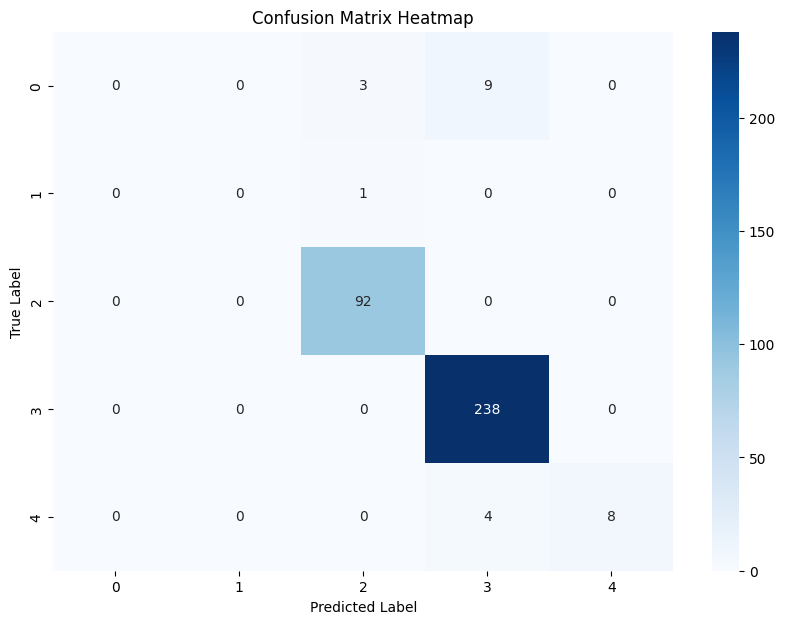

In [37]:
# Heatmap of the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


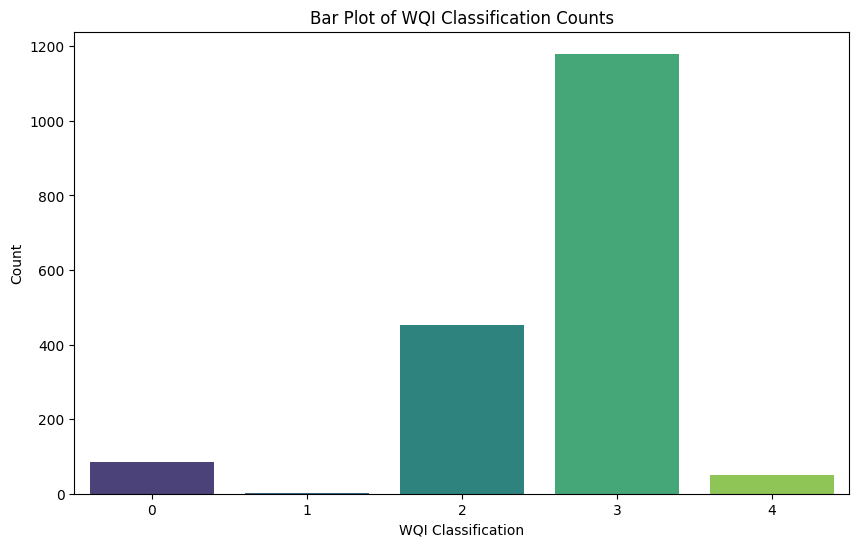

In [38]:
# Bar plot of WQI classification counts
wqi_class_counts = df_wqi['WQI clf'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=wqi_class_counts.index, y=wqi_class_counts.values, palette='viridis')
plt.title('Bar Plot of WQI Classification Counts')
plt.xlabel('WQI Classification')
plt.ylabel('Count')
plt.show()


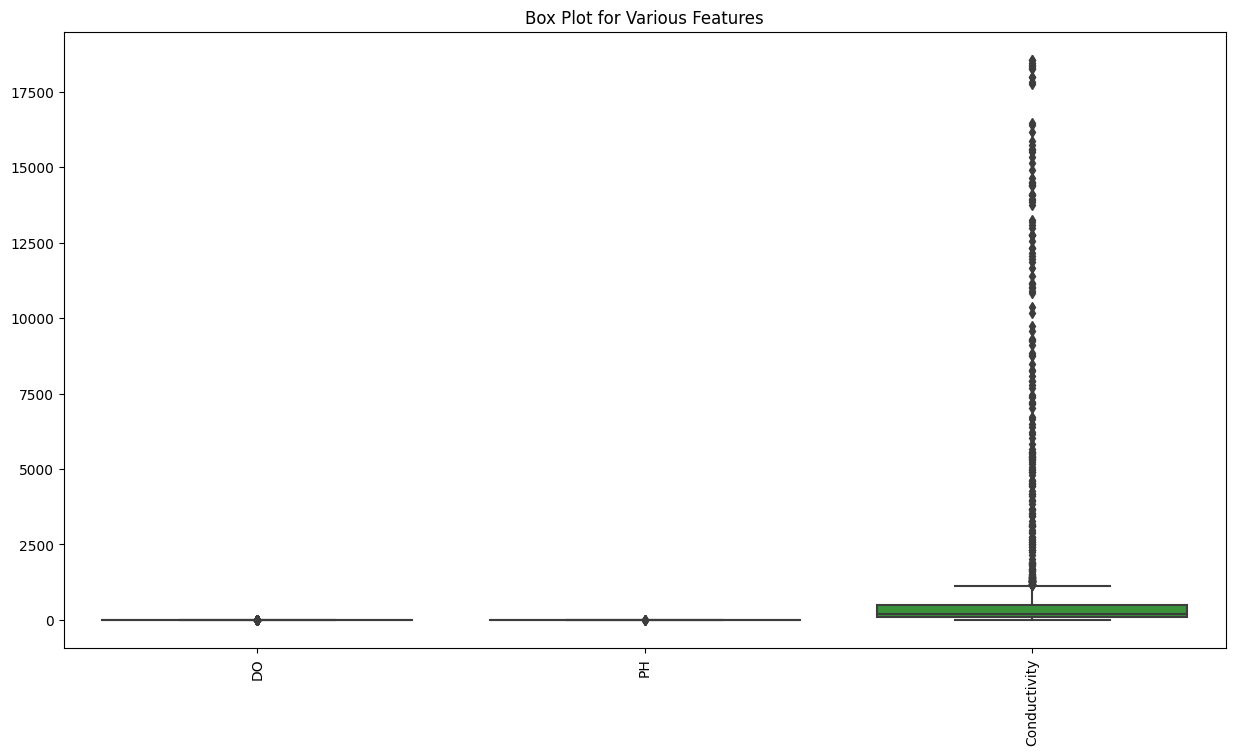

In [39]:
# Box plot for various features
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_num)
plt.title('Box Plot for Various Features')
plt.xticks(rotation=90)
plt.show()


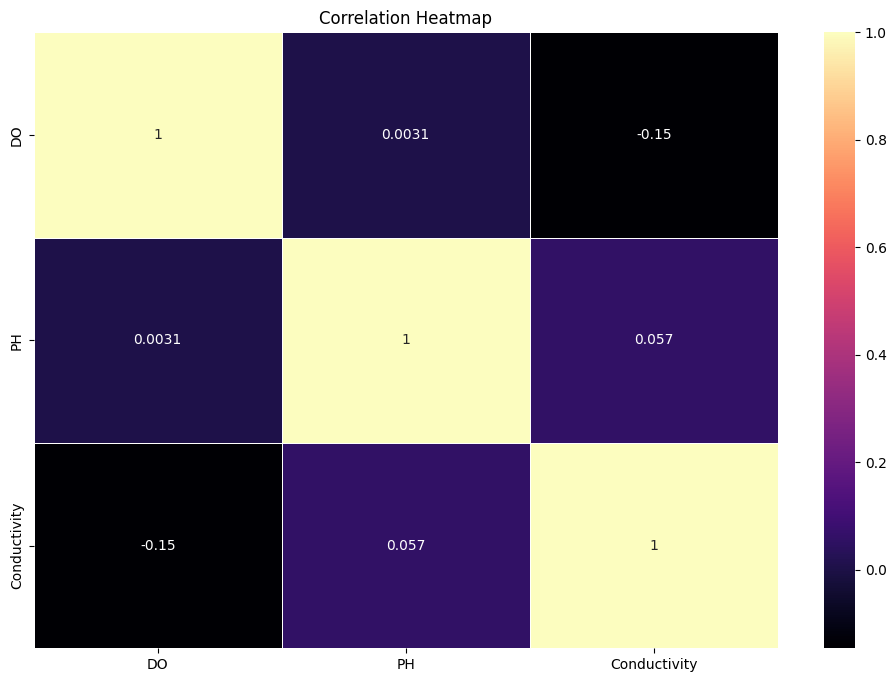

In [41]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df_num.corr()
sns.heatmap(corr_matrix, annot=True, cmap='magma', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()
